# <center>GAN para generar señales EKG</center>
## <center>PTB-XL Dataset</center>

In [18]:
import tensorflow as tf

tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [19]:
#!pip install pandas seaborn tqdm scikit-learn wfdb

In [20]:
import numpy as np, sys,os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
import wfdb
import tarfile
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import StratifiedKFold
from keras.preprocessing.sequence import pad_sequences
import math
import warnings
import os
import tensorflow as tf
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from scipy import signal
from tqdm import tqdm

In [21]:
def load_challenge_data(filename):
    """Load ECG files"""
    x = loadmat(filename)
    data = np.asarray(x['val'], dtype=np.float64)
    new_file = filename.replace('.mat','.hea')
    input_header_file = os.path.join(new_file)
    with open(input_header_file,'r') as f:
        header_data=f.readlines()
    return data, header_data


def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

In [22]:
def downsample_ecg(ecg, samples=1000, leads=12):
    """Function used to downsample ECGs from 500Hz to 100Hz"""
    new_ecg = np.zeros((samples,leads))
    for i,j in enumerate(ecg):
        new_ecg[:,i] = signal.resample(j,samples)
    return new_ecg

In [23]:
path_folder ="./WFDB/"

In [24]:
# Import ECGs to RAM
print("Importing real ECGs..")
ECGs = []
for ecgfilename in tqdm(sorted(os.listdir(path_folder))):
    if ecgfilename.endswith(".mat"):
        data = load_challenge_data(path_folder+"/" + ecgfilename)[0]
        ECGs.append(downsample_ecg(data))
ECGs = np.asarray(ECGs)

# Convert ECG unit from microvolt to millivolt
ECGs= ECGs/1000

print("A total of {} ECGs were loaded".format(len(ECGs)))

Importing real ECGs..


100%|██████████████████████████████████████████████████████████████████████████████████████████| 43674/43674 [00:09<00:00, 4480.57it/s]


A total of 21837 ECGs were loaded


A total of 21837 ECGs were loaded


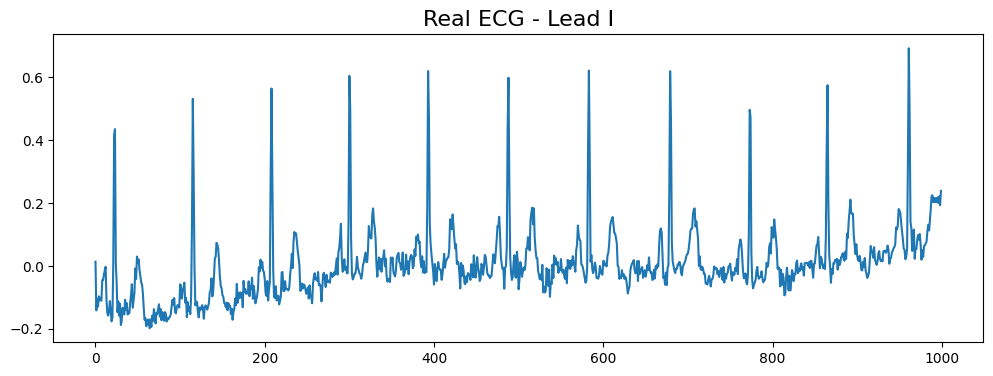

In [25]:
plt.figure(figsize=(12,4))
plt.title("Real ECG - Lead I", fontsize=16)
plt.plot(ECGs[0,:,0])
plt.show()

In [26]:
# generate n real samples with class labels
def generate_real_samples(ecgsignal,n):
    """Randomly pick n real ECG samples from the dataset and return it together with an array of n ones """
    # generate inputs in [-0.5, 0.5]
    X = ecgsignal[np.random.choice(ecgsignal.shape[0],n)]
    # generate class labels
    y = tf.ones((n, 1))
    return X, y
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n):
    """Generate random numbers used as input to the generator """
    # generate points in the latent space
    x_in = np.random.randn(latent_dim*n).reshape(n,latent_dim)
    # reshape into a batch of inputs for the network
    return np.expand_dims(x_in,1)
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(latent_dim,generator,n):
    """Use the generator to generate fake ECGs"""
    # generate points in latent space
    x_input = generate_latent_points(latent_dim,n)
    # predict outputs
    X = generator(x_input)
    # create class labels
    y = np.zeros((n, 1))
    return X, y

def compare_real_and_gen_ecg(generated_ecg):
    """Plot real and generated ECGs side by side"""
    plt.figure(figsize=(24,4))
    plt.subplot(1,2,1)
    plt.title("Generated (fake) ECG - Lead I", fontsize=16)
    plt.plot(generated_ecg[0,:,0])
    plt.subplot(1,2,2)
    plt.title("Real ECG - Lead I", fontsize=16)
    rand_idx = np.random.choice(np.arange(len(ECGs)))
    plt.plot(ECGs[rand_idx,:,0])
    plt.show()

In [27]:
def _inception_module(
    input_tensor,
    stride=1,
    activation="linear",
    use_bottleneck=True,
    kernel_size=40,
    bottleneck_size=32,
    nb_filters=32,
):

    if use_bottleneck and int(input_tensor.shape[-1]) > 1:
        input_inception = tf.keras.layers.Conv1D(
            filters=bottleneck_size,
            kernel_size=1,
            padding="same",
            activation=activation,
            use_bias=False,
        )(input_tensor)
    else:
        input_inception = input_tensor

    # kernel_size_s = [3, 5, 8, 11, 17]
    kernel_size_s = [kernel_size // (2**i) for i in range(3)]

    conv_list = []

    for i in range(len(kernel_size_s)):
        conv_list.append(
            tf.keras.layers.Conv1D(
                filters=nb_filters,
                kernel_size=kernel_size_s[i],
                strides=stride,
                padding="same",
                activation=activation,
                use_bias=False,
            )(input_inception)
        )

    max_pool_1 = tf.keras.layers.MaxPool1D(pool_size=3, strides=stride, padding="same")(
        input_tensor
    )

    conv_6 = tf.keras.layers.Conv1D(
        filters=nb_filters,
        kernel_size=1,
        padding="same",
        activation=activation,
        use_bias=False,
    )(max_pool_1)

    conv_list.append(conv_6)

    x = tf.keras.layers.Concatenate(axis=2)(conv_list)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation="relu")(x)
    return x


def _shortcut_layer(input_tensor, out_tensor):
    shortcut_y = tf.keras.layers.Conv1D(
        filters=int(out_tensor.shape[-1]), kernel_size=1, padding="same", use_bias=False
    )(input_tensor)
    shortcut_y = tf.keras.layers.BatchNormalization()(shortcut_y)

    x = tf.keras.layers.Add()([shortcut_y, out_tensor])
    x = tf.keras.layers.Activation("relu")(x)
    return x


def discriminator(
    input_shape = (1000,12),
    nb_classes=1,
    depth: int = 1,
    use_residual: bool = True,
)-> tf.keras.models.Model:
    """
    Model proposed by HI Fawas et al 2019 "Finding AlexNet for Time Series Classification - InceptionTime"
    """
    input_layer = tf.keras.layers.Input(input_shape)

    x = input_layer
    input_res = input_layer

    for d in range(depth):

        x = _inception_module(x)

        if use_residual and d % 3 == 2:
            x = _shortcut_layer(input_res, x)
            input_res = x

    gap_layer = tf.keras.layers.GlobalAveragePooling1D()(x)

    output_layer = tf.keras.layers.Dense(units=nb_classes, activation="sigmoid")(
        gap_layer
    )

    model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)
    model.compile(
        loss=tf.keras.losses.MeanAbsoluteError(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        metrics=[tf.keras.metrics.MeanSquaredError()],
    )

    return model



## Defining the discriminator

In [28]:
desc = discriminator()
print("Discriminator architecture:")
print(desc.summary())

Discriminator architecture:


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 1000, 12)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 1000, 32)  │        384 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 1000, 12)  │          0 │ input_layer_2[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 1000, 32)  │     40,960 │ conv1d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 1000, 32)  │     20,480 │ conv1d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 1000, 32)  │     10,240 │ conv1d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 1000, 32)  │        384 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 1000, 128) │          0 │ conv1d_6[0][0],   │
│ (Concatenate)       │                   │            │ conv1d_7[0][0],   │
│                     │                   │            │ conv1d_8[0][0],   │
│                     │                   │            │ conv1d_9[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1000, 128) │        512 │ concatenate_1[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 1000, 128) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ activation_1[0][… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │        129 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 73,089 (285.50 KB)

 Trainable params: 72,833 (284.50 KB)

 Non-trainable params: 256 (1.00 KB)

None


In [29]:
desc.load_weights("./descriminator_weights_round2.h5")

In [30]:
def generator():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(12*1000, use_bias=False, input_shape=(1,12)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Reshape((1000,12)))
    assert model.output_shape == (None, 1000, 12)  # Note: None is the batch size

    model.add(tf.keras.layers.Conv1DTranspose(128, 5, strides= 1, padding='same', use_bias=False))
    assert model.output_shape == (None, 1000, 128)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv1DTranspose(64,  5, strides= 1, padding='same', use_bias=False))
    assert model.output_shape == (None, 1000, 64)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv1DTranspose(12, 5, strides=1, padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 1000, 12)
    return model

## Defining the generator

In [31]:
gen = generator()
print("Generator architecture:")
print(gen.summary())

Generator architecture:


/opt/conda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 1, 12000)       │       144,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 1, 12000)       │        48,000 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 1, 12000)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 1000, 12)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_3              │ (None, 1000, 128)      │         7,680 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 1000, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 1000, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_4              │ (None, 1000, 64)       │        40,960 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 1000, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 1000, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_5              │ (None, 1000, 12)       │         3,840 │
│ (Conv1DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 245,248 (958.00 KB)

 Trainable params: 220,864 (862.75 KB)

 Non-trainable params: 24,384 (95.25 KB)

None


In [32]:
gen.load_weights("./generator_weights_round2.h5")

## Start training..

Before training:


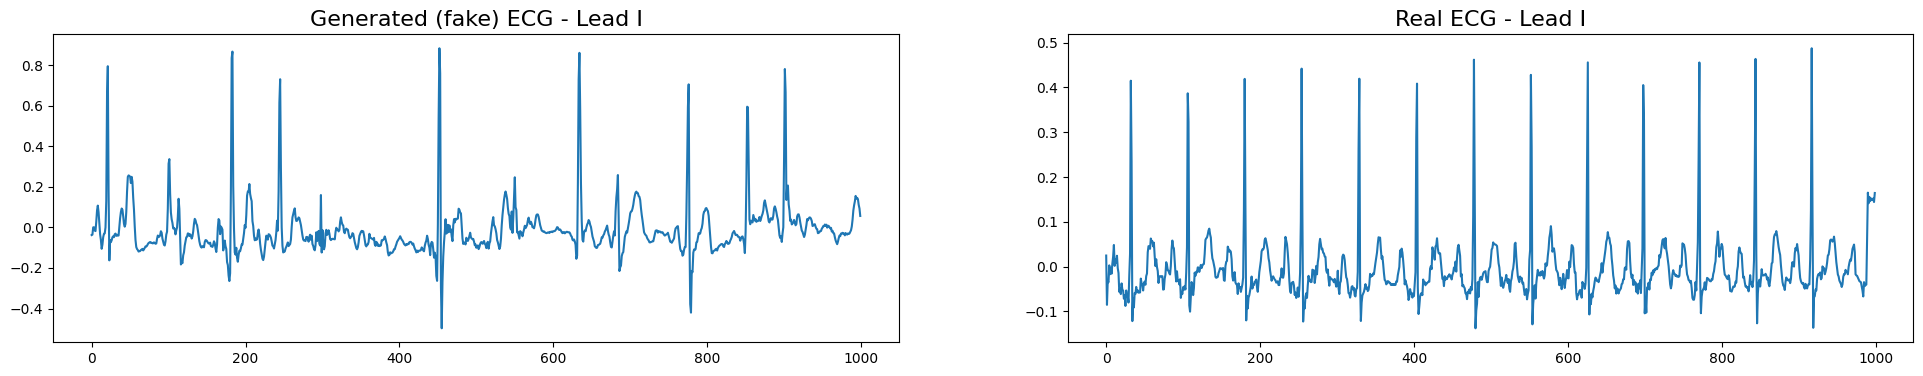

-------------------
epoch 0
Generator AUROC: 0.0
Generator loss: 1.0159429
Descriminator AUROC: 0.609375
Descriminator loss: 0.55313337
-------------------
epoch 1


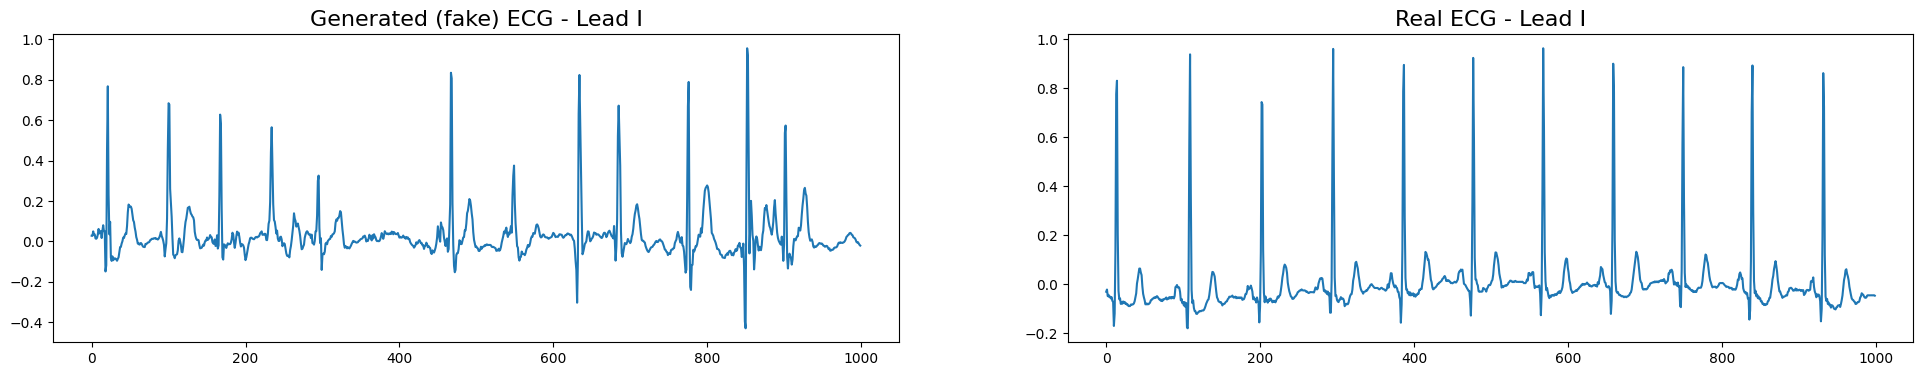

Generator AUROC: 0.0
Generator loss: 0.99583125
Descriminator AUROC: 0.52734375
Descriminator loss: 0.5443483
-------------------
epoch 2
Generator AUROC: 0.0
Generator loss: 1.0068487
Descriminator AUROC: 0.44140625
Descriminator loss: 0.538842
-------------------
epoch 3
Generator AUROC: 0.0
Generator loss: 1.0211425
Descriminator AUROC: 0.63671875
Descriminator loss: 0.5342478
-------------------
epoch 4
Generator AUROC: 0.0
Generator loss: 1.0380207
Descriminator AUROC: 0.5859375
Descriminator loss: 0.5269606
-------------------


In [33]:
batch_size=32
latent_dim=12
steps = len(ECGs)//32
half_batch = batch_size // 2
epochs = 5
#gen = generator()
#desc = discriminator()
init_lr_desc = 0.0002
init_lr_gen = 0.0004
opt_desc = tf.keras.optimizers.Adam(learning_rate=init_lr_desc,beta_1=0.5, beta_2=0.9)
opt_gen = tf.keras.optimizers.Adam(learning_rate=init_lr_gen,beta_1=0.5, beta_2=0.9)
print("Before training:")
res = gen(generate_latent_points(12,1))
compare_real_and_gen_ecg(res)
print("-------------------")
for epoch in range(epochs):
    if epoch % 5 == True:
        init_lr_desc = init_lr_desc/2
        init_lr_gen = init_lr_gen/2
        opt_desc.lr = init_lr_desc
        opt_gen.lr = init_lr_gen
    accu_loss_gan = []
    accu_loss_desc = []
    print("epoch {}".format(epoch))
    for step in range(steps):
        x_real, y_real = generate_real_samples(ECGs,half_batch)
        x_fake, y_fake = generate_fake_samples(latent_dim,gen,half_batch)
        X_train = np.vstack([x_real,x_fake])
        y_train = np.vstack([y_real,y_fake])
        p = np.random.permutation(len(y_train)) #shuffle

        with tf.GradientTape() as tape:
            pred_desc = desc(X_train[p])
            loss_desc = tf.keras.losses.binary_crossentropy(y_train[p], pred_desc)
        accu_loss_desc.append(loss_desc)
        grads = tape.gradient(loss_desc, desc.trainable_variables)
        opt_desc.apply_gradients(zip(grads, desc.trainable_variables))
        

        with tf.GradientTape() as tape:
            x_latent = generate_latent_points(latent_dim,batch_size)
            x_gan = gen(x_latent)
            y_gan = np.ones((batch_size, 1))
            pred_gan = desc(x_gan)
            loss_gan = tf.keras.losses.binary_crossentropy(y_gan, pred_gan)
        accu_loss_gan.append(loss_gan)
        grads = tape.gradient(loss_gan, gen.trainable_variables)
        opt_gen.apply_gradients(zip(grads, gen.trainable_variables))
        #summarize_performance(1,gen, desc, latent_dim, ECGs)
    if epoch % 5 == True:
        res = gen(generate_latent_points(12,1))
        compare_real_and_gen_ecg(res)
    print("Generator AUROC:", roc_auc_score(np.concatenate([y_gan.ravel(),np.array([0])]),np.concatenate([np.asarray(pred_gan).ravel(),np.array([0.5])])))
    print("Generator loss:", np.mean(np.asarray(accu_loss_gan)))
    print("Descriminator AUROC:", roc_auc_score(y_train.ravel(),np.asarray(pred_desc).ravel()))   
    print("Descriminator loss:", np.mean(np.asarray(accu_loss_desc)))
    print("-------------------")

In [ ]:
gen.save_weights("generator_weights_round_new.h5")

In [ ]:
desc.save_weights("descriminator_weights_round_new.h5")